In [3]:
from lib.utils import *
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm
from torch.nn.functional import relu
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
X,y = load_nursing_by_index(1,data_dir=f'../data/nursingv1/',label_dir=f'../data/nursingv1_musa/')

In [ ]:
"""
MLP just based on x-signal
"""
trainloader = DataLoader(TensorDataset(X[:,0].unsqueeze(1),y),batch_size=32,shuffle=True)

class MLP1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1,5)
        self.fc2 = nn.Linear(5,1)
    def forward(self, x):
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        return x  
device = 'cuda'
model = MLP1d().to(device=device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

In [ ]:
lossi = []
model.train()

for i in range(10):
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        
plt.plot(lossi)
print(torch.tensor(lossi).mean())
test_evaluation(trainloader,model,criterion)

In [ ]:
x = torch.linspace(-20,20,1000).unsqueeze(1)
plt.plot(x,torch.sigmoid(model(x.cuda()).flatten().detach().cpu()))

In [ ]:
"""
MLP based on xyz signal
"""
trainloader = DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True)

class MLP1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3,300)
        self.fc2 = nn.Linear(300,1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        return x  
device = 'cuda'
model = MLP1d().to(device=device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

In [ ]:
lossi = []
model.train()

for i in range(50):
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        
plt.plot(lossi)
print(torch.tensor(lossi).mean())
test_evaluation(trainloader,model,criterion)
#.0525

In [ ]:
logits = model(X.to(device))
logits = torch.sigmoid(logits.detach().cpu().flatten())
df = pd.DataFrame(X.numpy(),columns=['x','y','z'])
df['logits'] = logits.numpy()*10
fig = px.line(df)
fig.show(renderer='browser')

In [ ]:
"""
Add some windowed context to xyz signal
"""
X,y = load_nursing_by_index(0,data_dir=f'../data/nursingv1/',label_dir=f'../data/nursingv1_musa/')
window_size = 101
Xw,yw = window_nursing(X,y,window_size=window_size)

In [ ]:
"""
MLP based on windowed xyz signal
"""
trainloader = DataLoader(TensorDataset(Xw,yw),batch_size=32,shuffle=True)

class MLP1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(window_size*3,10)
        self.fc2 = nn.Linear(10,1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        return x  
device = 'cuda'
model = MLP1d().to(device=device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

In [ ]:
lossi = []
model.train()

for i in range(20):
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        
plt.plot(lossi)
print(torch.tensor(lossi).mean())
test_evaluation(trainloader,model,criterion)

In [ ]:
logits = model(Xw.to(device))
logits = torch.sigmoid(torch.cat([torch.zeros(window_size//2),logits.detach().cpu().flatten(),torch.zeros(window_size//2)]))
df = pd.DataFrame(X.numpy(),columns=['x','y','z'])
df['logits'] = logits.numpy()*10
fig = px.line(df)
fig.show(renderer='browser')

In [ ]:
window_size = 101
testloader = DataLoader(TensorDataset(*window_nursing(*load_nursing_by_index(10,data_dir=f'../data/nursingv1/',label_dir=f'../data/nursingv1_andrew/'),window_size=window_size)),batch_size=32,shuffle=True)
test_evaluation(testloader,model,criterion)

In [2]:
"""
Load more than 1 and train test split
"""
X,y = load_nursing_list(range(10),data_dir=f'../data/nursingv1/',label_dir=f'../data/nursingv1_andrew/')

In [9]:
"""
MLP based on xyz signal
"""
trainloader = DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True)

class MLP1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3,32)
        self.fc2 = nn.Linear(32,1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        return x  
device = 'cuda'
model = MLP1d().to(device=device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

Params:  161


100%|██████████| 9554/9554 [00:07<00:00, 1338.51it/s]


tensor(0.0999)


100%|██████████| 9554/9554 [00:03<00:00, 2567.09it/s]


(0.09805476190643188,
 tensor([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]),
 tensor([[0.0085],
         [0.0340],
         [0.0028],
         ...,
         [0.0467],
         [0.0015],
         [0.0391]]))

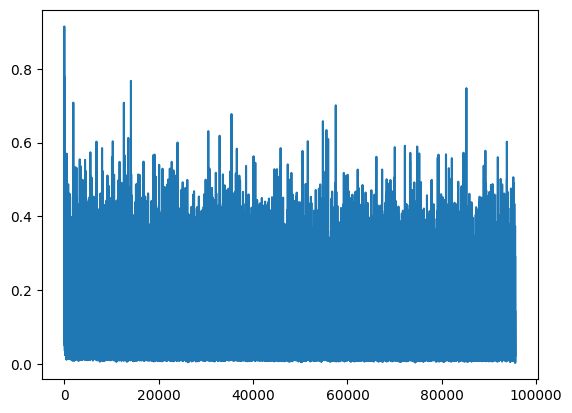

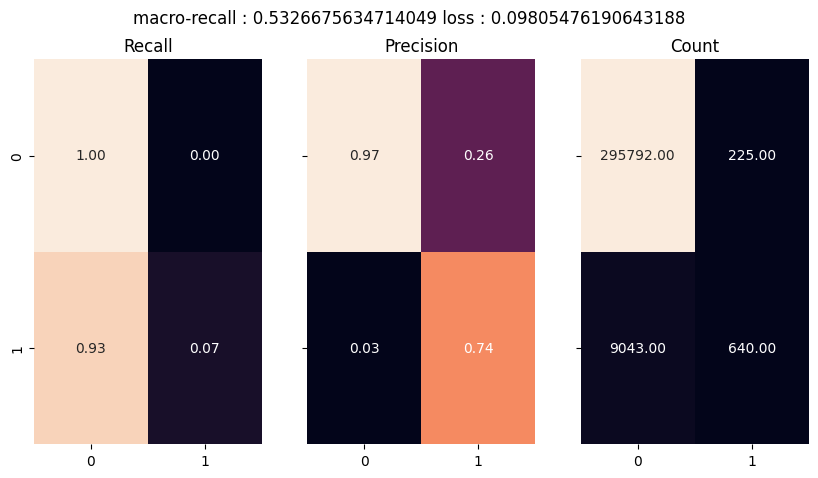

In [10]:
lossi = []
model.train()

for i in range(10):
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        
plt.plot(lossi)
print(torch.tensor(lossi).mean())
test_evaluation(trainloader,model,criterion)
#.0525

In [12]:
"""
TTS xyz
"""
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.5,stratify=y)
trainloader = DataLoader(TensorDataset(X_train,y_train),batch_size=32,shuffle=True)
devloader = DataLoader(TensorDataset(X_test,y_test),batch_size=32,shuffle=True)

100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


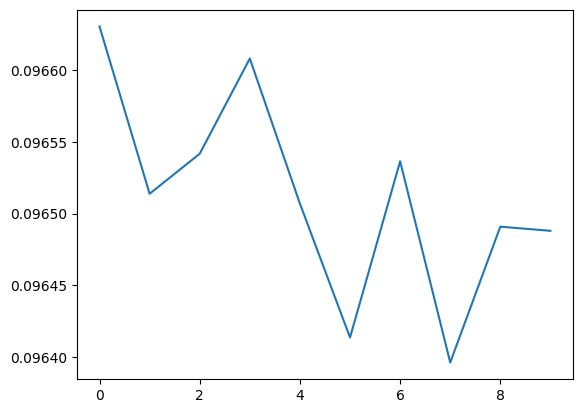

In [15]:
loss_tr = []
loss_dev = []
pbar = tqdm(range(10))

for epoch in pbar:
    # train loop
    model.train()
    loss_tr_total = 0
    for (X_tr,y_tr) in trainloader:
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tr_total += loss.item()
    loss_tr.append(loss_tr_total/len(trainloader))

    # dev loop
    model.eval()
    loss_dev_total = 0
    for (X_dv,y_dv) in devloader:
        X_dv,y_dv = X_dv.to(device),y_dv.to(device)
        logits = model(X_dv)
        loss = criterion(logits,y_dv)
        loss_dev_total += loss.item()
    loss_dev.append(loss_dev_total/len(devloader))
plt.plot(loss_tr)
plt.plot(loss_dev)

100%|██████████| 4777/4777 [00:01<00:00, 2542.52it/s]


(0.09663625059367437,
 tensor([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]),
 tensor([[0.0158],
         [0.0046],
         [0.1749],
         ...,
         [0.0058],
         [0.0739],
         [0.0218]]))

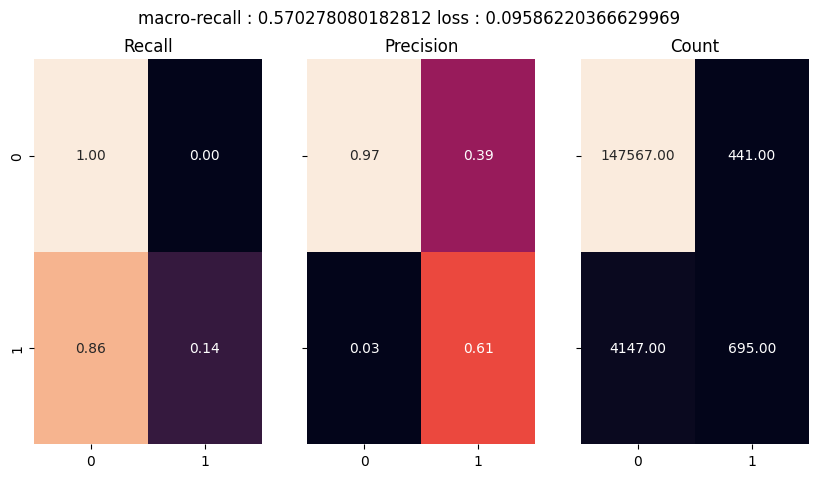

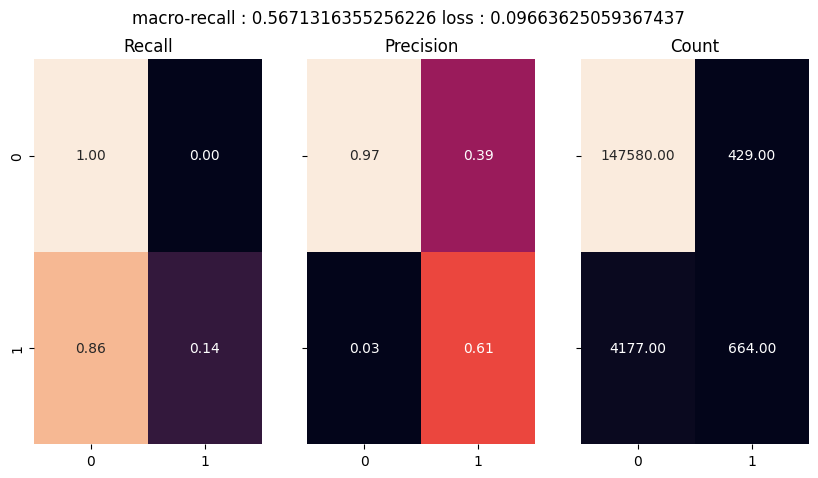

In [16]:
test_evaluation(trainloader,model,criterion)
test_evaluation(devloader,model,criterion)

In [4]:
"""
Load windowed list, train test split
"""
window_size = 101
train_idx = list(range(71))
X,y = load_and_window_nursing_list(train_idx,data_dir=f'../data/nursingv1/',label_dir=f'../data/nursingv1_andrew/',window_size=window_size)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.8,stratify=y,random_state=0,shuffle=True)
trainloader = DataLoader(TensorDataset(X_train,y_train),batch_size=32,shuffle=True)
devloader = DataLoader(TensorDataset(X_test,y_test),batch_size=32,shuffle=True)